# VGGNet variant

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import os
import random
from sklearn.metrics import precision_score, recall_score, f1_score , roc_curve, auc , confusion_matrix
import seaborn as sns

In [8]:
!unrar x  /content/drive/MyDrive/DNN_HW2/NN_HW2_Face_Emotion.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/DNN_HW2/NN_HW2_Face_Emotion.rar


Would you like to replace the existing file TUNE/anger/image0029836.jpg
  3408 bytes, modified on 2023-11-10 08:26
with a new one
  3408 bytes, modified on 2023-11-10 08:26

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Q

Program aborted


In [9]:
print(sorted(os.listdir("/content/TRAIN")))
print(sorted(os.listdir("/content/TUNE")))
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(os.listdir("/content/TRAIN")))}
print(class_to_idx)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}


In [10]:
from torch.utils.data import Dataset, ConcatDataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = self.load_images()

    def load_images(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                images.append((image_path, class_idx))
        return images

    def apply_augmentation(self, image):
        default_transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        if self.transform:
            return self.transform(default_transform(image))
        else:
            return default_transform(image)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path, label = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        image = self.apply_augmentation(image)
        return image, label

# Create an instance of the dataset with no augmentation
dataset = CustomDataset(root_dir='/content/TRAIN/')

# Create two additional instances with different augmentations
augmented_dataset_1 = CustomDataset(root_dir='/content/TRAIN/', transform=transforms.RandomRotation(degrees=20))
augmented_dataset_2 = CustomDataset(root_dir='/content/TRAIN/', transform=transforms.RandomHorizontalFlip())
augmented_dataset_3 = CustomDataset(root_dir='/content/TRAIN/', transform=transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)))

# Concatenate the original dataset with augmented datasets
augmented_dataset = ConcatDataset([dataset, augmented_dataset_1, augmented_dataset_2, augmented_dataset_3])


In [12]:

def plot_train_examples(transform = None) :
  dataset = augmented_dataset.datasets[2]
  print(len(dataset))
  class_images = {class_name: [] for class_name in dataset.classes}
  for image, label in dataset:
    class_name = dataset.classes[label]
    if len(class_images[class_name]) < 2:
        class_images[class_name].append(image)

  fig, axs = plt.subplots(len(dataset.classes), 2, figsize=(10, 2 * len(dataset.classes)))
  fig.suptitle('Two Images from Each Class')
  print("start to plot")
  for i, class_name in enumerate(dataset.classes):
    img1 = class_images[class_name][0]
    # print(img1.shape)
    img1 = np.transpose(class_images[class_name][0].numpy(), (1, 2, 0))
    img2 = np.transpose(class_images[class_name][1].numpy(), (1, 2, 0))
    axs[i, 0].imshow(img1)

    axs[i, 0].set_title(f'{class_name} - Image 1')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(img2)
    axs[i, 1].set_title(f'{class_name} - Image 2')
    axs[i, 1].axis('off')

plt.show()


8000
start to plot


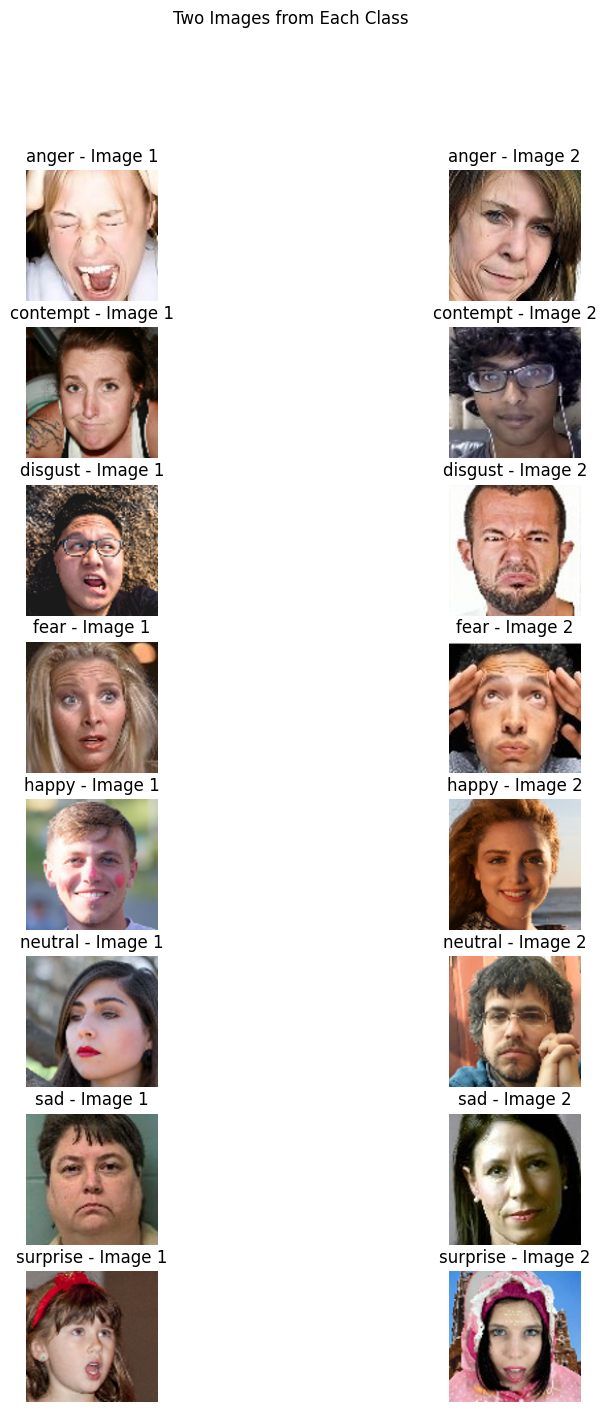

In [13]:

plot_train_examples(transform = None)

In [14]:
data_transform = transforms.Compose([
    transforms.RandomRotation(degrees=20),  # Randomly rotate 20%
    transforms.RandomHorizontalFlip(), # horiziontal flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # 10% translation
    transforms.Lambda(lambda x: x.clamp(0, 1)),  # min max normalization [0, 1]
])


# plot_train_examples(transform=data_transform)

In [15]:

class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        self.cnns = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),  # dropout
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),  # dropout
            nn.Linear(1024, 8),
            nn.Softmax(dim = 1 )
        )

    def forward(self, x):
        x = self.cnns(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.classifier(x)

        return x



In [17]:

train_loss = []
eval_loss = []
train_acc = []
eval_acc = []



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the dataset with augmentations
dataset = CustomDataset(root_dir='/content/TRAIN/')

# Create three additional instances with different augmentations
augmented_dataset_1 = CustomDataset(root_dir='/content/TRAIN/', transform=transforms.RandomRotation(degrees=20))
augmented_dataset_2 = CustomDataset(root_dir='/content/TRAIN/', transform=transforms.RandomHorizontalFlip())
augmented_dataset_3 = CustomDataset(root_dir='/content/TRAIN/', transform=transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)))

# Concatenate the original dataset with augmented datasets
concatenated_dataset = ConcatDataset([dataset, augmented_dataset_1, augmented_dataset_2, augmented_dataset_3])

# 15% for eval
train_size = int(0.85 * len(concatenated_dataset))
eval_size = len(concatenated_dataset) - train_size
train_dataset, eval_dataset = random_split(concatenated_dataset, [train_size, eval_size])

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)


model = VGGNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 24
for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Evaluation
    model.eval()
    total_eval_loss = 0
    correct_eval = 0
    total_eval = 0
    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_eval_loss += loss.item()

            _, predicted = outputs.max(1)
            total_eval += labels.size(0) # add to total equal to size of batch
            correct_eval += predicted.eq(labels).sum().item()

    average_eval_loss = total_eval_loss / len(eval_loader)
    eval_accuracy = correct_eval / total_eval

    # Print statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {average_loss:.4f}, training accuracy: {train_accuracy * 100:.2f}%, '
          f'Eval Loss: {average_eval_loss:.4f}, eval accuracy: {eval_accuracy * 100:.2f}%')
    train_loss.append(average_loss)
    eval_loss.append(average_eval_loss)
    train_acc.append(train_accuracy * 100)
    eval_acc.append(eval_accuracy * 100 )


Epoch 1/24, Training Loss: 1.9723, training accuracy: 28.12%, Eval Loss: 1.8925, eval accuracy: 37.02%
Epoch 2/24, Training Loss: 1.8610, training accuracy: 40.08%, Eval Loss: 1.8786, eval accuracy: 38.48%
Epoch 3/24, Training Loss: 1.7952, training accuracy: 47.08%, Eval Loss: 1.7994, eval accuracy: 46.52%
Epoch 4/24, Training Loss: 1.7746, training accuracy: 49.21%, Eval Loss: 1.7542, eval accuracy: 51.29%
Epoch 5/24, Training Loss: 1.7579, training accuracy: 51.03%, Eval Loss: 1.7682, eval accuracy: 50.02%
Epoch 6/24, Training Loss: 1.7367, training accuracy: 53.19%, Eval Loss: 1.7408, eval accuracy: 53.00%
Epoch 7/24, Training Loss: 1.7157, training accuracy: 55.36%, Eval Loss: 1.7700, eval accuracy: 49.96%
Epoch 8/24, Training Loss: 1.7102, training accuracy: 55.88%, Eval Loss: 1.7109, eval accuracy: 55.85%
Epoch 9/24, Training Loss: 1.6972, training accuracy: 57.25%, Eval Loss: 1.7213, eval accuracy: 54.60%
Epoch 10/24, Training Loss: 1.6836, training accuracy: 58.68%, Eval Loss:

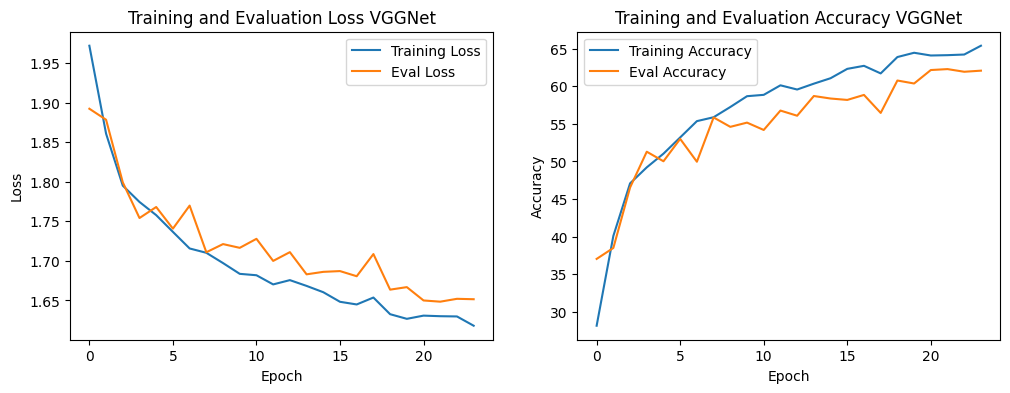

In [18]:
# Plotting
plt.figure(figsize=(12, 4))

# loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Eval Loss')
plt.title('Training and Evaluation Loss VGGNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(eval_acc, label='Eval Accuracy')
plt.title('Training and Evaluation Accuracy VGGNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:

data_transform = transforms.Compose([
    transforms.RandomRotation(degrees=20),  # Randomly rotate 20%
    transforms.RandomHorizontalFlip(), # horiziontal flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # 10% translation
    transforms.Lambda(lambda x: x.clamp(0, 1)),  # min max normalization [0, 1]
])
dataset_tune = CustomDataset(root_dir='/content/TUNE/', transform = data_transform)
print(len(dataset_tune))
print(len(dataset))

1600
8000


In [20]:
#fine tune
# Freeze the weights of the cnns layers
for param in model.cnns.parameters():
    param.requires_grad = False
data_transform = transforms.Compose([
    transforms.RandomRotation(degrees=20),  # Randomly rotate 20%
    transforms.RandomHorizontalFlip(), # horiziontal flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # 10% translation
    transforms.Lambda(lambda x: x.clamp(0, 1)),  # min max normalization [0, 1]
])
batch_size = 128
tuneDataset = CustomDataset(root_dir='/content/TUNE/', transform = data_transform)
fine_tune_train_loader = DataLoader(tuneDataset, batch_size=batch_size, shuffle=True)
pretrained_model = model

tune_train_loss = []
tune_eval_loss = []
tune_train_acc = []
tune_eval_acc = []

num_epochs = 15
for epoch in range(num_epochs):
    # Training
    pretrained_model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in fine_tune_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(fine_tune_train_loader)
    train_accuracy = correct_train / total_train

    # Evaluation
    pretrained_model.eval()
    total_eval_loss = 0
    correct_eval = 0
    total_eval = 0
    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pretrained_model(inputs)
            loss = criterion(outputs, labels)
            total_eval_loss += loss.item()

            _, predicted = outputs.max(1)
            total_eval += labels.size(0)
            correct_eval += predicted.eq(labels).sum().item()

    average_eval_loss = total_eval_loss / len(eval_loader)
    eval_accuracy = correct_eval / total_eval

    # Print statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'TUNE Training Loss: {average_loss:.4f}, TUNE Training Accuracy: {train_accuracy * 100:.2f}%, '
          f'Eval Loss: {average_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%')
    tune_train_loss.append(average_loss)
    tune_eval_loss.append(average_eval_loss)
    tune_train_acc.append(train_accuracy * 100)
    tune_eval_acc.append(eval_accuracy * 100 )



Epoch 1/15, TUNE Training Loss: 1.8624, TUNE Training Accuracy: 40.81%, Eval Loss: 1.6446, Eval Accuracy: 62.46%
Epoch 2/15, TUNE Training Loss: 1.8693, TUNE Training Accuracy: 40.06%, Eval Loss: 1.6640, Eval Accuracy: 60.71%
Epoch 3/15, TUNE Training Loss: 1.8472, TUNE Training Accuracy: 42.00%, Eval Loss: 1.6732, Eval Accuracy: 59.88%
Epoch 4/15, TUNE Training Loss: 1.8549, TUNE Training Accuracy: 41.62%, Eval Loss: 1.6720, Eval Accuracy: 59.90%
Epoch 5/15, TUNE Training Loss: 1.8535, TUNE Training Accuracy: 42.06%, Eval Loss: 1.6601, Eval Accuracy: 61.00%
Epoch 6/15, TUNE Training Loss: 1.8612, TUNE Training Accuracy: 41.31%, Eval Loss: 1.6523, Eval Accuracy: 61.92%
Epoch 7/15, TUNE Training Loss: 1.8659, TUNE Training Accuracy: 40.50%, Eval Loss: 1.6658, Eval Accuracy: 60.42%
Epoch 8/15, TUNE Training Loss: 1.8629, TUNE Training Accuracy: 40.88%, Eval Loss: 1.6711, Eval Accuracy: 60.02%
Epoch 9/15, TUNE Training Loss: 1.8576, TUNE Training Accuracy: 41.12%, Eval Loss: 1.6543, Eval 

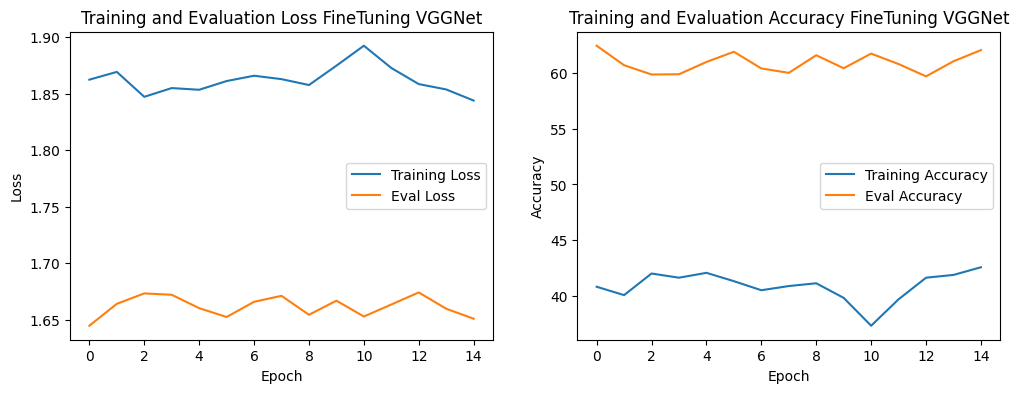

In [21]:
# Plotting
plt.figure(figsize=(12, 4))

# loss
plt.subplot(1, 2, 1)
plt.plot(tune_train_loss, label='Training Loss')
plt.plot(tune_eval_loss, label='Eval Loss')
plt.title('Training and Evaluation Loss FineTuning VGGNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(tune_train_acc, label='Training Accuracy')
plt.plot(tune_eval_acc, label='Eval Accuracy')
plt.title('Training and Evaluation Accuracy FineTuning VGGNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

(4800,)
(4800,)


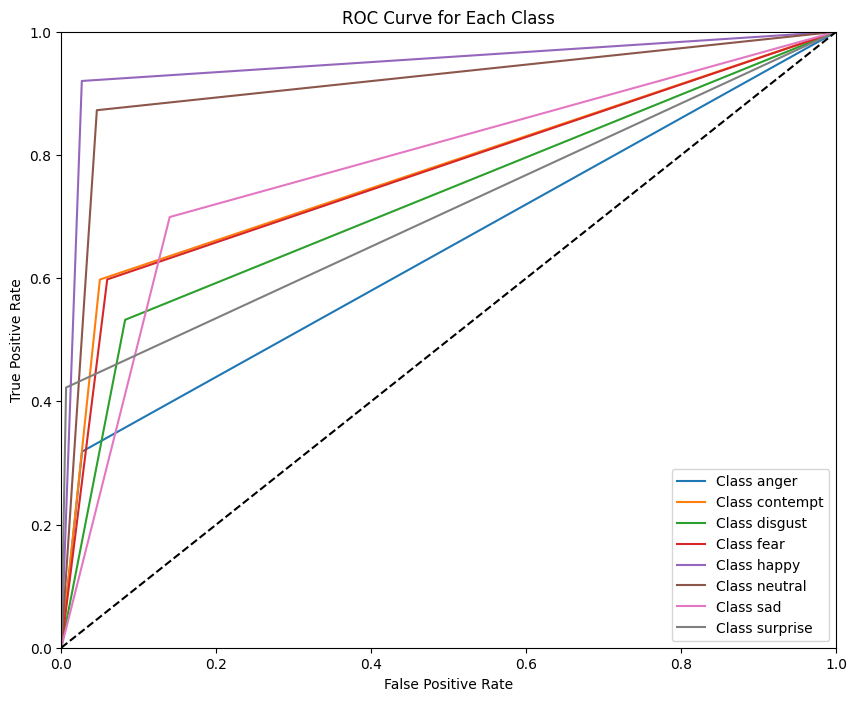

In [22]:


# Eval mode
model.eval()

true_labels_eval = []
predicted_labels_eval = []

# Iterate over the evaluation dataset
with torch.no_grad():
    for inputs, labels in eval_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        labels_np = labels.cpu().numpy()
        outputs_np = predicted.cpu().numpy()

        true_labels_eval.extend(labels_np)
        predicted_labels_eval.extend(outputs_np)

true_labels_eval = np.array(true_labels_eval)
predicted_labels_eval = np.array(predicted_labels_eval)


print(true_labels_eval.shape)
print(predicted_labels_eval.shape)
# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
className =  {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}
class_index_to_name = {v: k for k, v in className.items()}
for i in range(8):
    fpr, tpr, _ = roc_curve((true_labels_eval == i), (predicted_labels_eval == i))
    plt.plot(fpr, tpr, label=f'Class {class_index_to_name[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

In [23]:
precision_dict = {}
recall_dict = {}
f1_dict = {}

for class_index in range(8) :
    true_class = (true_labels_eval == class_index)
    predicted_class = (predicted_labels_eval == class_index)
    precision = precision_score(true_class, predicted_class)
    recall = recall_score(true_class, predicted_class)
    f1 = f1_score(true_class, predicted_class)
    precision_dict[class_index_to_name[class_index]] = precision
    recall_dict[class_index_to_name[class_index]] = recall
    f1_dict[class_index_to_name[class_index]] = f1

print("Precision for each class:", precision_dict)
print("Recall for each class:", recall_dict)
print("F1 score for each class:", f1_dict)

Precision for each class: {'anger': 0.639871382636656, 'contempt': 0.6333333333333333, 'disgust': 0.47424242424242424, 'fear': 0.5745762711864407, 'happy': 0.8355555555555556, 'neutral': 0.7204610951008645, 'sad': 0.4188118811881188, 'surprise': 0.9103448275862069}
Recall for each class: {'anger': 0.3184, 'contempt': 0.597682119205298, 'disgust': 0.532312925170068, 'fear': 0.5978835978835979, 'happy': 0.9200652528548124, 'neutral': 0.8726003490401396, 'sad': 0.6991735537190082, 'surprise': 0.4224}
F1 score for each class: {'anger': 0.42521367521367526, 'contempt': 0.6149914821124361, 'disgust': 0.501602564102564, 'fear': 0.5859982713915299, 'happy': 0.875776397515528, 'neutral': 0.7892659826361483, 'sad': 0.5238390092879257, 'surprise': 0.5770491803278689}


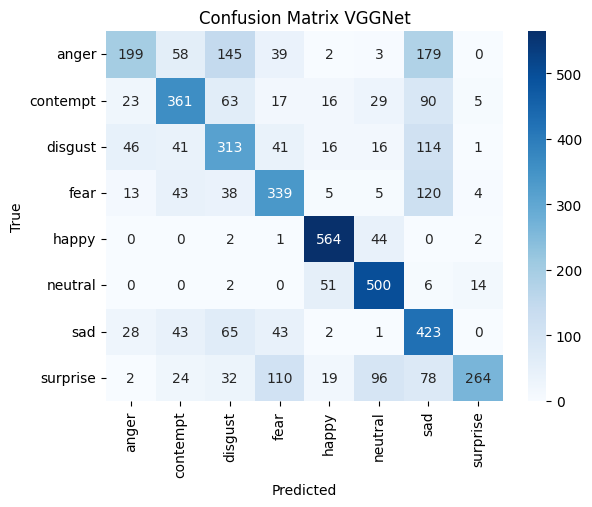

In [24]:
cm = confusion_matrix(true_labels_eval, predicted_labels_eval)
classes = list(class_index_to_name.values())

# Plot confusion matrix  as a heatmap
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Set labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix VGGNet')

# Display the plot
plt.show()

(27200,)
(27200,)
Precision for each class: {'anger': 0.6868571428571428, 'contempt': 0.6923076923076923, 'disgust': 0.5419161676646707, 'fear': 0.6203782105560259, 'happy': 0.8219284603421462, 'neutral': 0.7497519841269841, 'sad': 0.4565097967405237, 'surprise': 0.891290920321186}
Recall for each class: {'anger': 0.35614814814814816, 'contempt': 0.6651943462897526, 'disgust': 0.5835287221570926, 'fear': 0.6402563355665598, 'happy': 0.9362267493356953, 'neutral': 0.882112634957689, 'sad': 0.7343151693667157, 'surprise': 0.4275555555555556}
F1 score for each class: {'anger': 0.46907317073170735, 'contempt': 0.6784802522901335, 'disgust': 0.5619531470505221, 'fear': 0.6301605504587154, 'happy': 0.8753623188405797, 'neutral': 0.8105644188228984, 'sad': 0.5630081300813008, 'surprise': 0.5778934721665999}


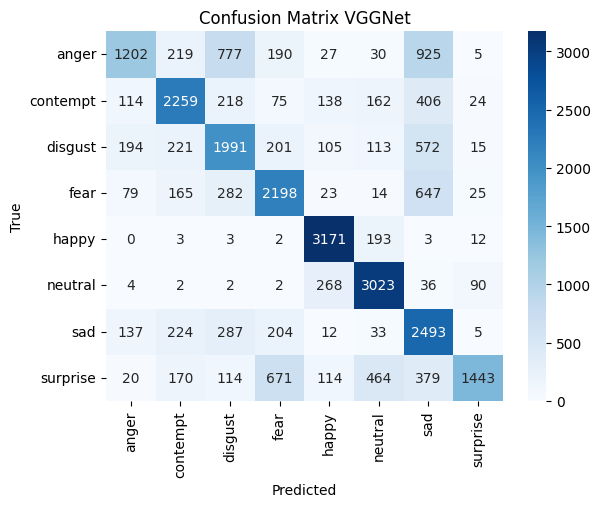

In [25]:


# Eval mode
model.eval()

true_labels_train = []
predicted_labels_train = []

# Iterate over the train dataset
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        labels_np = labels.cpu().numpy()
        outputs_np = predicted.cpu().numpy()

        true_labels_train.extend(labels_np)
        predicted_labels_train.extend(outputs_np)

true_labels_train = np.array(true_labels_train)
predicted_labels_train = np.array(predicted_labels_train)


print(true_labels_train.shape)
print(predicted_labels_train.shape)



precision_dict_train = {}
recall_dict_train = {}
f1_dict_train = {}

for class_index in range(8) :
    true_class = (true_labels_train == class_index)
    predicted_class = (predicted_labels_train == class_index)
    precision = precision_score(true_class, predicted_class)
    recall = recall_score(true_class, predicted_class)
    f1 = f1_score(true_class, predicted_class)
    precision_dict_train[class_index_to_name[class_index]] = precision
    recall_dict_train[class_index_to_name[class_index]] = recall
    f1_dict_train[class_index_to_name[class_index]] = f1

print("Precision for each class:", precision_dict_train)
print("Recall for each class:", recall_dict_train)
print("F1 score for each class:", f1_dict_train)


cm = confusion_matrix(true_labels_train, predicted_labels_train)
classes = list(class_index_to_name.values())

# Plot confusion matrix VGGNet as a heatmap
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Set labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix VGGNet')

# Display the plot
plt.show()